In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import copy
from itertools import repeat
import shutil
import time
import math
import array

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

from sklearn.base import BaseEstimator
from sklearn.metrics import r2_score, mean_absolute_error

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

import optuna
from joblib import Parallel, delayed, dump, load
from joblib.externals.loky import get_reusable_executor

from ray import train, tune
from ray.tune.search.optuna import OptunaSearch

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

from cmaes import CMA, CMAwM

from tqdm.notebook import tqdm

plt.style.use('seaborn-v0_8-whitegrid')

# Load data

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [2]:
df = pd.read_csv('train.csv')
df

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
df.describe().T

count           mean           std      min        25%  \
Id             1460.0     730.500000    421.610009      1.0     365.75   
MSSubClass     1460.0      56.897260     42.300571     20.0      20.00   
LotFrontage    1201.0      70.049958     24.284752     21.0      59.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
OverallQual    1460.0       6.099315      1.382997      1.0       5.00   
OverallCond    1460.0       5.575342      1.112799      1.0       5.00   
YearBuilt      1460.0    1971.267808     30.202904   1872.0    1954.00   
YearRemodAdd   1460.0    1984.865753     20.645407   1950.0    1967.00   
MasVnrArea     1452.0     103.685262    181.066207      0.0       0.00   
BsmtFinSF1     1460.0     443.639726    456.098091      0.0       0.00   
BsmtFinSF2     1460.0      46.549315    161.319273      0.0       0.00   
BsmtUnfSF      1460.0     567.240411    441.866955      0.0     223.00   
TotalBsmtSF    1460.0    1057.429452    438.705324      0.0     795.75   
1stFlrSF       1460.0    1162.626712    386.587738    334.0     882.00   
2ndFlrSF       1460.0     346.992466    436.528436      0.0       0.00   
LowQualFinSF   1460.0       5.844521     48.623081      0.0       0.00   
GrLivArea      1460.0    1515.463699    525.480383    334.0    1129.50   
BsmtFullBath   1460.0       0.425342      0.518911      0.0       0.00   
BsmtHalfBath   1460.0       0.057534      0.238753      0.0       0.00   
FullBath       1460.0       1.565068      0.550916      0.0       1.00   
HalfBath       1460.0       0.382877      0.502885      0.0       0.00   
BedroomAbvGr   1460.0       2.866438      0.815778      0.0       2.00   
KitchenAbvGr   1460.0       1.046575      0.220338      0.0       1.00   
TotRmsAbvGrd   1460.0       6.517808      1.625393      2.0       5.00   
Fireplaces     1460.0       0.613014      0.644666      0.0       0.00   
GarageYrBlt    1379.0    1978.506164     24.689725   1900.0    1961.00   
GarageCars     1460.0       1.767123      0.747315      0.0       1.00   
GarageArea     1460.0     472.980137    213.804841      0.0     334.50   
WoodDeckSF     1460.0      94.244521    125.338794      0.0       0.00   
OpenPorchSF    1460.0      46.660274     66.256028      0.0       0.00   
EnclosedPorch  1460.0      21.954110     61.119149      0.0       0.00   
3SsnPorch      1460.0       3.409589     29.317331      0.0       0.00   
ScreenPorch    1460.0      15.060959     55.757415      0.0       0.00   
PoolArea       1460.0       2.758904     40.177307      0.0       0.00   
MiscVal        1460.0      43.489041    496.123024      0.0       0.00   
MoSold         1460.0       6.321918      2.703626      1.0       5.00   
YrSold         1460.0    2007.815753      1.328095   2006.0    2007.00   
SalePrice      1460.0  180921.195890  79442.502883  34900.0  129975.00   

                    50%        75%       max  
Id                730.5    1095.25    1460.0  
MSSubClass         50.0      70.00     190.0  
LotFrontage        69.0      80.00     313.0  
LotArea          9478.5   11601.50  215245.0  
OverallQual         6.0       7.00      10.0  
OverallCond         5.0       6.00       9.0  
YearBuilt        1973.0    2000.00    2010.0  
YearRemodAdd     1994.0    2004.00    2010.0  
MasVnrArea          0.0     166.00    1600.0  
BsmtFinSF1        383.5     712.25    5644.0  
BsmtFinSF2          0.0       0.00    1474.0  
BsmtUnfSF         477.5     808.00    2336.0  
TotalBsmtSF       991.5    1298.25    6110.0  
1stFlrSF         1087.0    1391.25    4692.0  
2ndFlrSF            0.0     728.00    2065.0  
LowQualFinSF        0.0       0.00     572.0  
GrLivArea        1464.0    1776.75    5642.0  
BsmtFullBath        0.0       1.00       3.0  
BsmtHalfBath        0.0       0.00       2.0  
FullBath            2.0       2.00       3.0  
HalfBath            0.0       1.00       2.0  
BedroomAbvGr        3.0       3.00       8.0  
KitchenAbvGr        1.0       1.00       3.0  
T

# Clean-up and transform data

In [5]:
# drop columns with NaN
df.dropna(axis=1, inplace=True)
# drop irrelevant columns
df.drop(columns=['Id'], inplace=True)
# drop major outliers
df = df[df['BsmtFinSF1'] <= 5000]
df = df[df['MiscVal'] <= 5000]
df = df[df['LotArea'] <= 100000]

In [6]:
columns_non_categorical = df.select_dtypes(exclude='object').columns.to_list()
columns_non_categorical.sort()
columns_non_categorical.remove('SalePrice')
columns_non_categorical = ['SalePrice'] + columns_non_categorical

In [7]:
# alphabetically sort columns, keep target first
df_temp = df[['SalePrice']]
df.drop(columns=['SalePrice'], inplace=True)
df.sort_index(axis=1, inplace=True)
df = pd.concat([df_temp, df], axis=1)
del df_temp
df

SalePrice  1stFlrSF  2ndFlrSF  3SsnPorch  BedroomAbvGr BldgType  \
0        208500       856       854          0             3     1Fam   
1        181500      1262         0          0             3     1Fam   
2        223500       920       866          0             3     1Fam   
3        140000       961       756          0             3     1Fam   
4        250000      1145      1053          0             4     1Fam   
...         ...       ...       ...        ...           ...      ...   
1455     175000       953       694          0             3     1Fam   
1456     210000      2073         0          0             3     1Fam   
1457     266500      1188      1152          0             4     1Fam   
1458     142125      1078         0          0             2     1Fam   
1459     147500      1256         0          0             3     1Fam   

      BsmtFinSF1  BsmtFinSF2  BsmtFullBath  BsmtHalfBath  ...  SaleType  \
0            706           0             1             0  ...        WD   
1            978           0             0             1  ...        WD   
2            486           0             1             0  ...        WD   
3            216           0             1             0  ...        WD   
4            655           0             1             0  ...        WD   
...          ...         ...           ...           ...  ...       ...   
1455           0           0             0             0  ...        WD   
1456         790         163             1             0  ...        WD   
1457         275           0             0             0  ...        WD   
1458          49        1029             1             0  ...        WD   
1459         830         290             1             0  ...        WD   

     ScreenPorch Street TotRmsAbvGrd  TotalBsmtSF Utilities WoodDeckSF  \
0              0   Pave            8          856    AllPub          0   
1              0   Pave            6         1262    AllPub        298   
2              0   Pave            6          920    AllPub          0   
3              0   Pave            7          756    AllPub          0   
4              0   Pave            9         1145    AllPub        192   
...          ...    ...          ...          ...       ...        ...   
1455           0   Pave            7          953    AllPub          0   
1456           0   Pave            7         1542    AllPub        349   
1457           0   Pave            9         1152    AllPub          0   
1458           0   Pave            5         1078    AllPub        366   
1459           0   Pave            6         1256    AllPub        736   

     YearBuilt YearRemodAdd  YrSold  
0         2003         2003    2008  
1         1976         1976    2007  
2         2001         2002    2008  
3         1915         1970    2006  
4         2000         2000    2008  
...        ...          ...     ...  
1455      1999         2000    2007  
1456      1978         1988    2010  
1457      1941         2006    2010  
1458      1950         1996    2010  
1459      1965         1965    2008  

[1453 rows x 61 columns]

# Examine the data after transformations

Histograms:

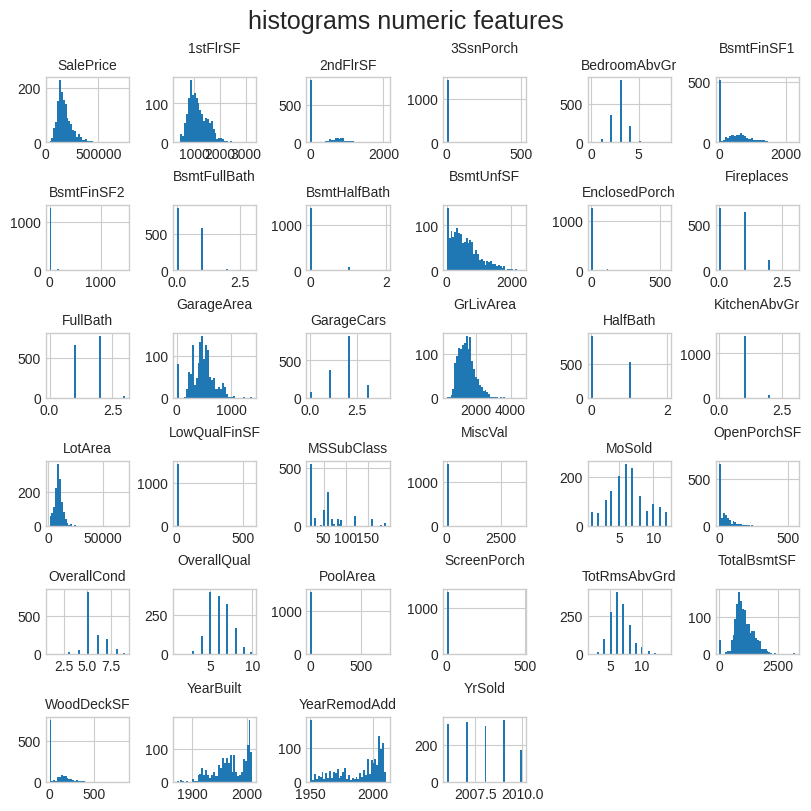

In [8]:
fig = plt.figure(figsize=(8, 8), layout="constrained")
fig.suptitle('histograms numeric features', fontsize=18)
grid_size = math.ceil(np.sqrt(df.select_dtypes(exclude='object').shape[1]))
for i, item in enumerate(df.select_dtypes(exclude='object').columns, 1):
    ax = plt.subplot(grid_size, grid_size, i)
    ax.hist(df[item], bins=40)
    ax_title = item
    if i % 2 == 0:
        ax_title += "\n"
    ax.set_title(ax_title)
    ax.title.set_fontsize(10)
plt.show()

Box plots:

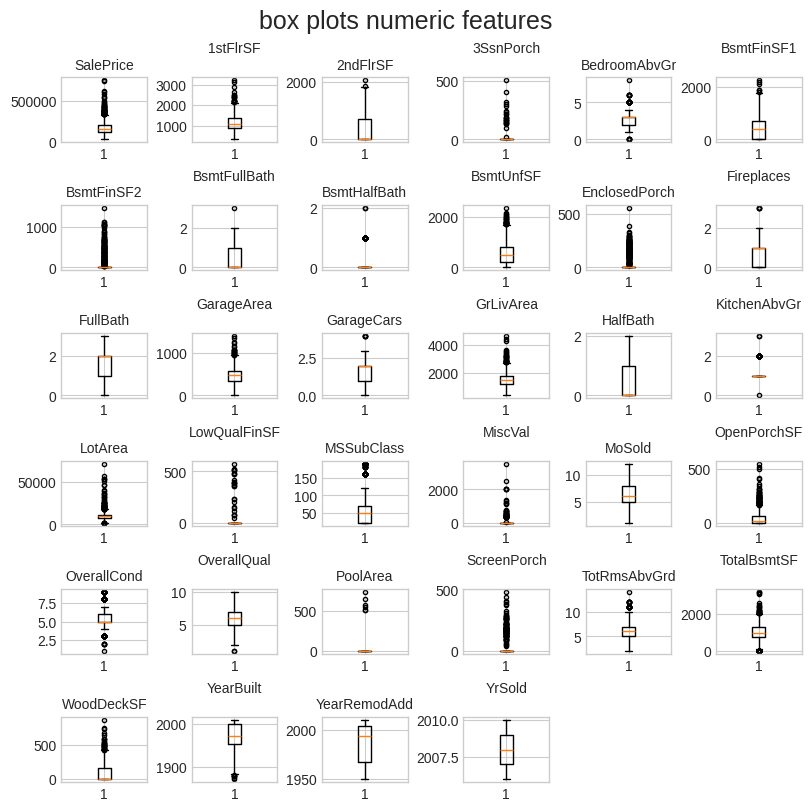

In [9]:
fig = plt.figure(figsize=(8, 8), layout="constrained")
fig.suptitle('box plots numeric features', fontsize=18)
grid_size = math.ceil(np.sqrt(df.select_dtypes(exclude='object').shape[1]))
for i, item in enumerate(df.select_dtypes(exclude='object').columns, 1):
    ax = plt.subplot(grid_size, grid_size, i)
    ax.boxplot(df[item], sym='.')
    ax_title = item
    if i % 2 == 0:
        ax_title += "\n"
    ax.set_title(ax_title)
    ax.title.set_fontsize(10)
plt.show()

Scatterplots:

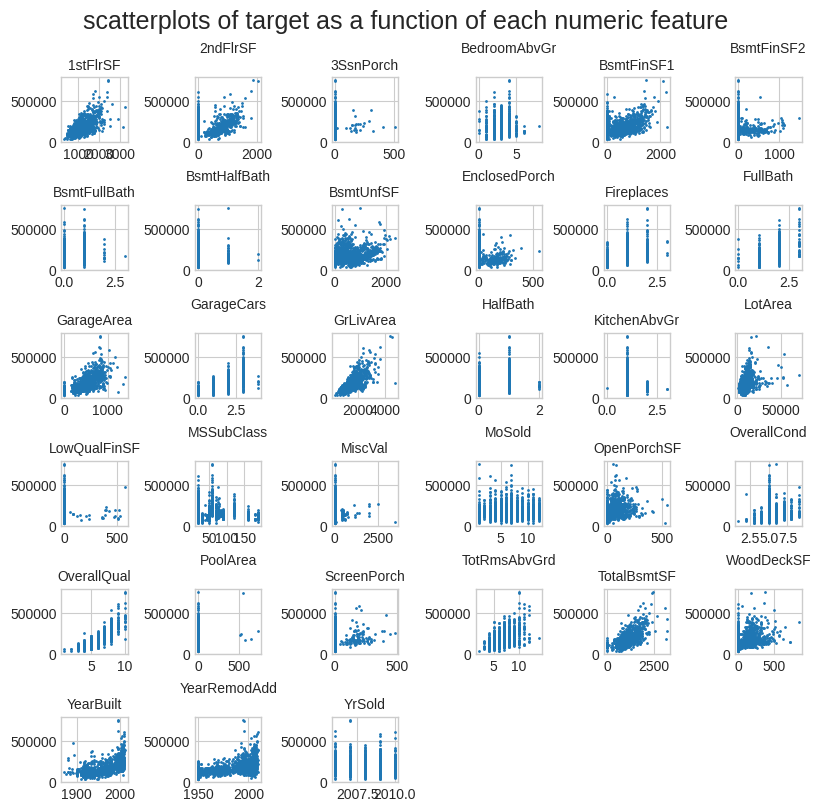

In [10]:
fig = plt.figure(figsize=(8, 8), layout="constrained")
fig.suptitle('scatterplots of target as a function of each numeric feature', fontsize=18)
grid_size = math.ceil(np.sqrt(df.select_dtypes(exclude='object').shape[1]))
for i, item in enumerate([f for f in df.select_dtypes(exclude='object').columns if f not in ['SalePrice']], 1):
    ax = plt.subplot(grid_size, grid_size, i)
    ax_title = item
    if i % 2 == 0:
        ax_title += "\n"
    ax.set_title(ax_title)
    ax.title.set_fontsize(10)
    plt.scatter(df[item], df['SalePrice'], s=1)
plt.show()

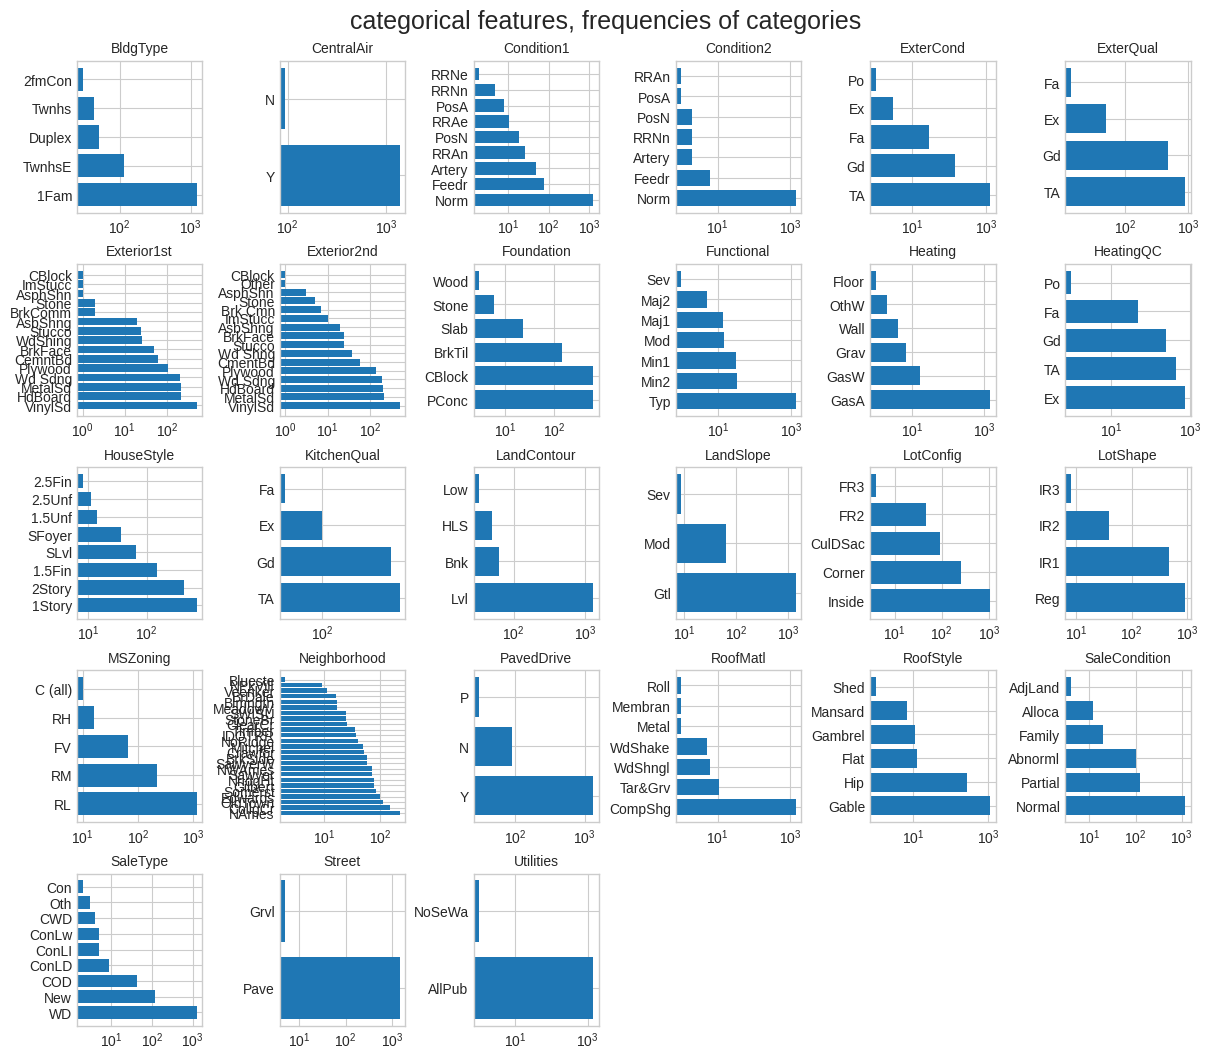

In [11]:
fig = plt.figure(figsize=(12, 12), layout="constrained")
fig.suptitle('categorical features, frequencies of categories', fontsize=18)
grid_size = math.ceil(np.sqrt(df.select_dtypes(include='object').shape[1]))
for i, item in enumerate(df.select_dtypes(include='object').columns, 1):
    vcounts = df[item].value_counts()
    ax = plt.subplot(grid_size, grid_size, i)
    ax.barh(vcounts.index.to_list(), vcounts.values.tolist(), log=True)
    ax_title = item
    # if i % 2 == 0:
    #    ax_title += "\n"
    ax.set_title(ax_title)
    ax.title.set_fontsize(10)
plt.show()

In [12]:
# dummy categorical columns
df = pd.concat(
    [df.select_dtypes(exclude='object'), pd.get_dummies(df.select_dtypes(include='object'), dtype=int)], axis=1
)
# alphabetically sort columns, keep target first
df_temp = df[['SalePrice']]
df.drop(columns=['SalePrice'], inplace=True)
df.sort_index(axis=1, inplace=True)
df = pd.concat([df_temp, df], axis=1)
del df_temp
df

SalePrice  1stFlrSF  2ndFlrSF  3SsnPorch  BedroomAbvGr  BldgType_1Fam  \
0        208500       856       854          0             3              1   
1        181500      1262         0          0             3              1   
2        223500       920       866          0             3              1   
3        140000       961       756          0             3              1   
4        250000      1145      1053          0             4              1   
...         ...       ...       ...        ...           ...            ...   
1455     175000       953       694          0             3              1   
1456     210000      2073         0          0             3              1   
1457     266500      1188      1152          0             4              1   
1458     142125      1078         0          0             2              1   
1459     147500      1256         0          0             3              1   

      BldgType_2fmCon  BldgType_Duplex  BldgType_Twnhs  BldgType_TwnhsE  ...  \
0                   0                0               0                0  ...   
1                   0                0               0                0  ...   
2                   0                0               0                0  ...   
3                   0                0               0                0  ...   
4                   0                0               0                0  ...   
...               ...              ...             ...              ...  ...   
1455                0                0               0                0  ...   
1456                0                0               0                0  ...   
1457                0                0               0                0  ...   
1458                0                0               0                0  ...   
1459                0                0               0                0  ...   

      Street_Grvl  Street_Pave  TotRmsAbvGrd  TotalBsmtSF  Utilities_AllPub  \
0               0            1             8          856                 1   
1               0            1             6         1262                 1   
2               0            1             6          920                 1   
3               0            1             7          756                 1   
4               0            1             9         1145                 1   
...           ...          ...           ...          ...               ...   
1455            0            1             7          953                 1   
1456            0            1             7         1542                 1   
1457            0            1             9         1152                 1   
1458            0            1             5         1078                 1   
1459            0            1             6         1256                 1   

      Utilities_NoSeWa  WoodDeckSF  YearBuilt  YearRemodAdd  YrSold  
0                    0           0       2003          2003    2008  
1                    0         298       1976          1976    2007  
2                    0           0       2001          2002    2008  
3                    0           0       1915          1970    2006  
4                    0         192       2000          2000    2008  
...                ...         ...        ...           ...     ...  
1455                 0           0       1999          2000    2007  
1456                 0         349       1978          1988    2010  
1457                 0           0       1941          2006    2010  
1458                 0         366       1950          1996    2010  
1459                 0         736       1965          1965    2008  

[1453 rows x 214 columns]

Correlation heatmap:

Red is positive. Blue is negative. Black is 0.
Target is first in the list. The features are alphabetically sorted.
Download the image and view it locally.


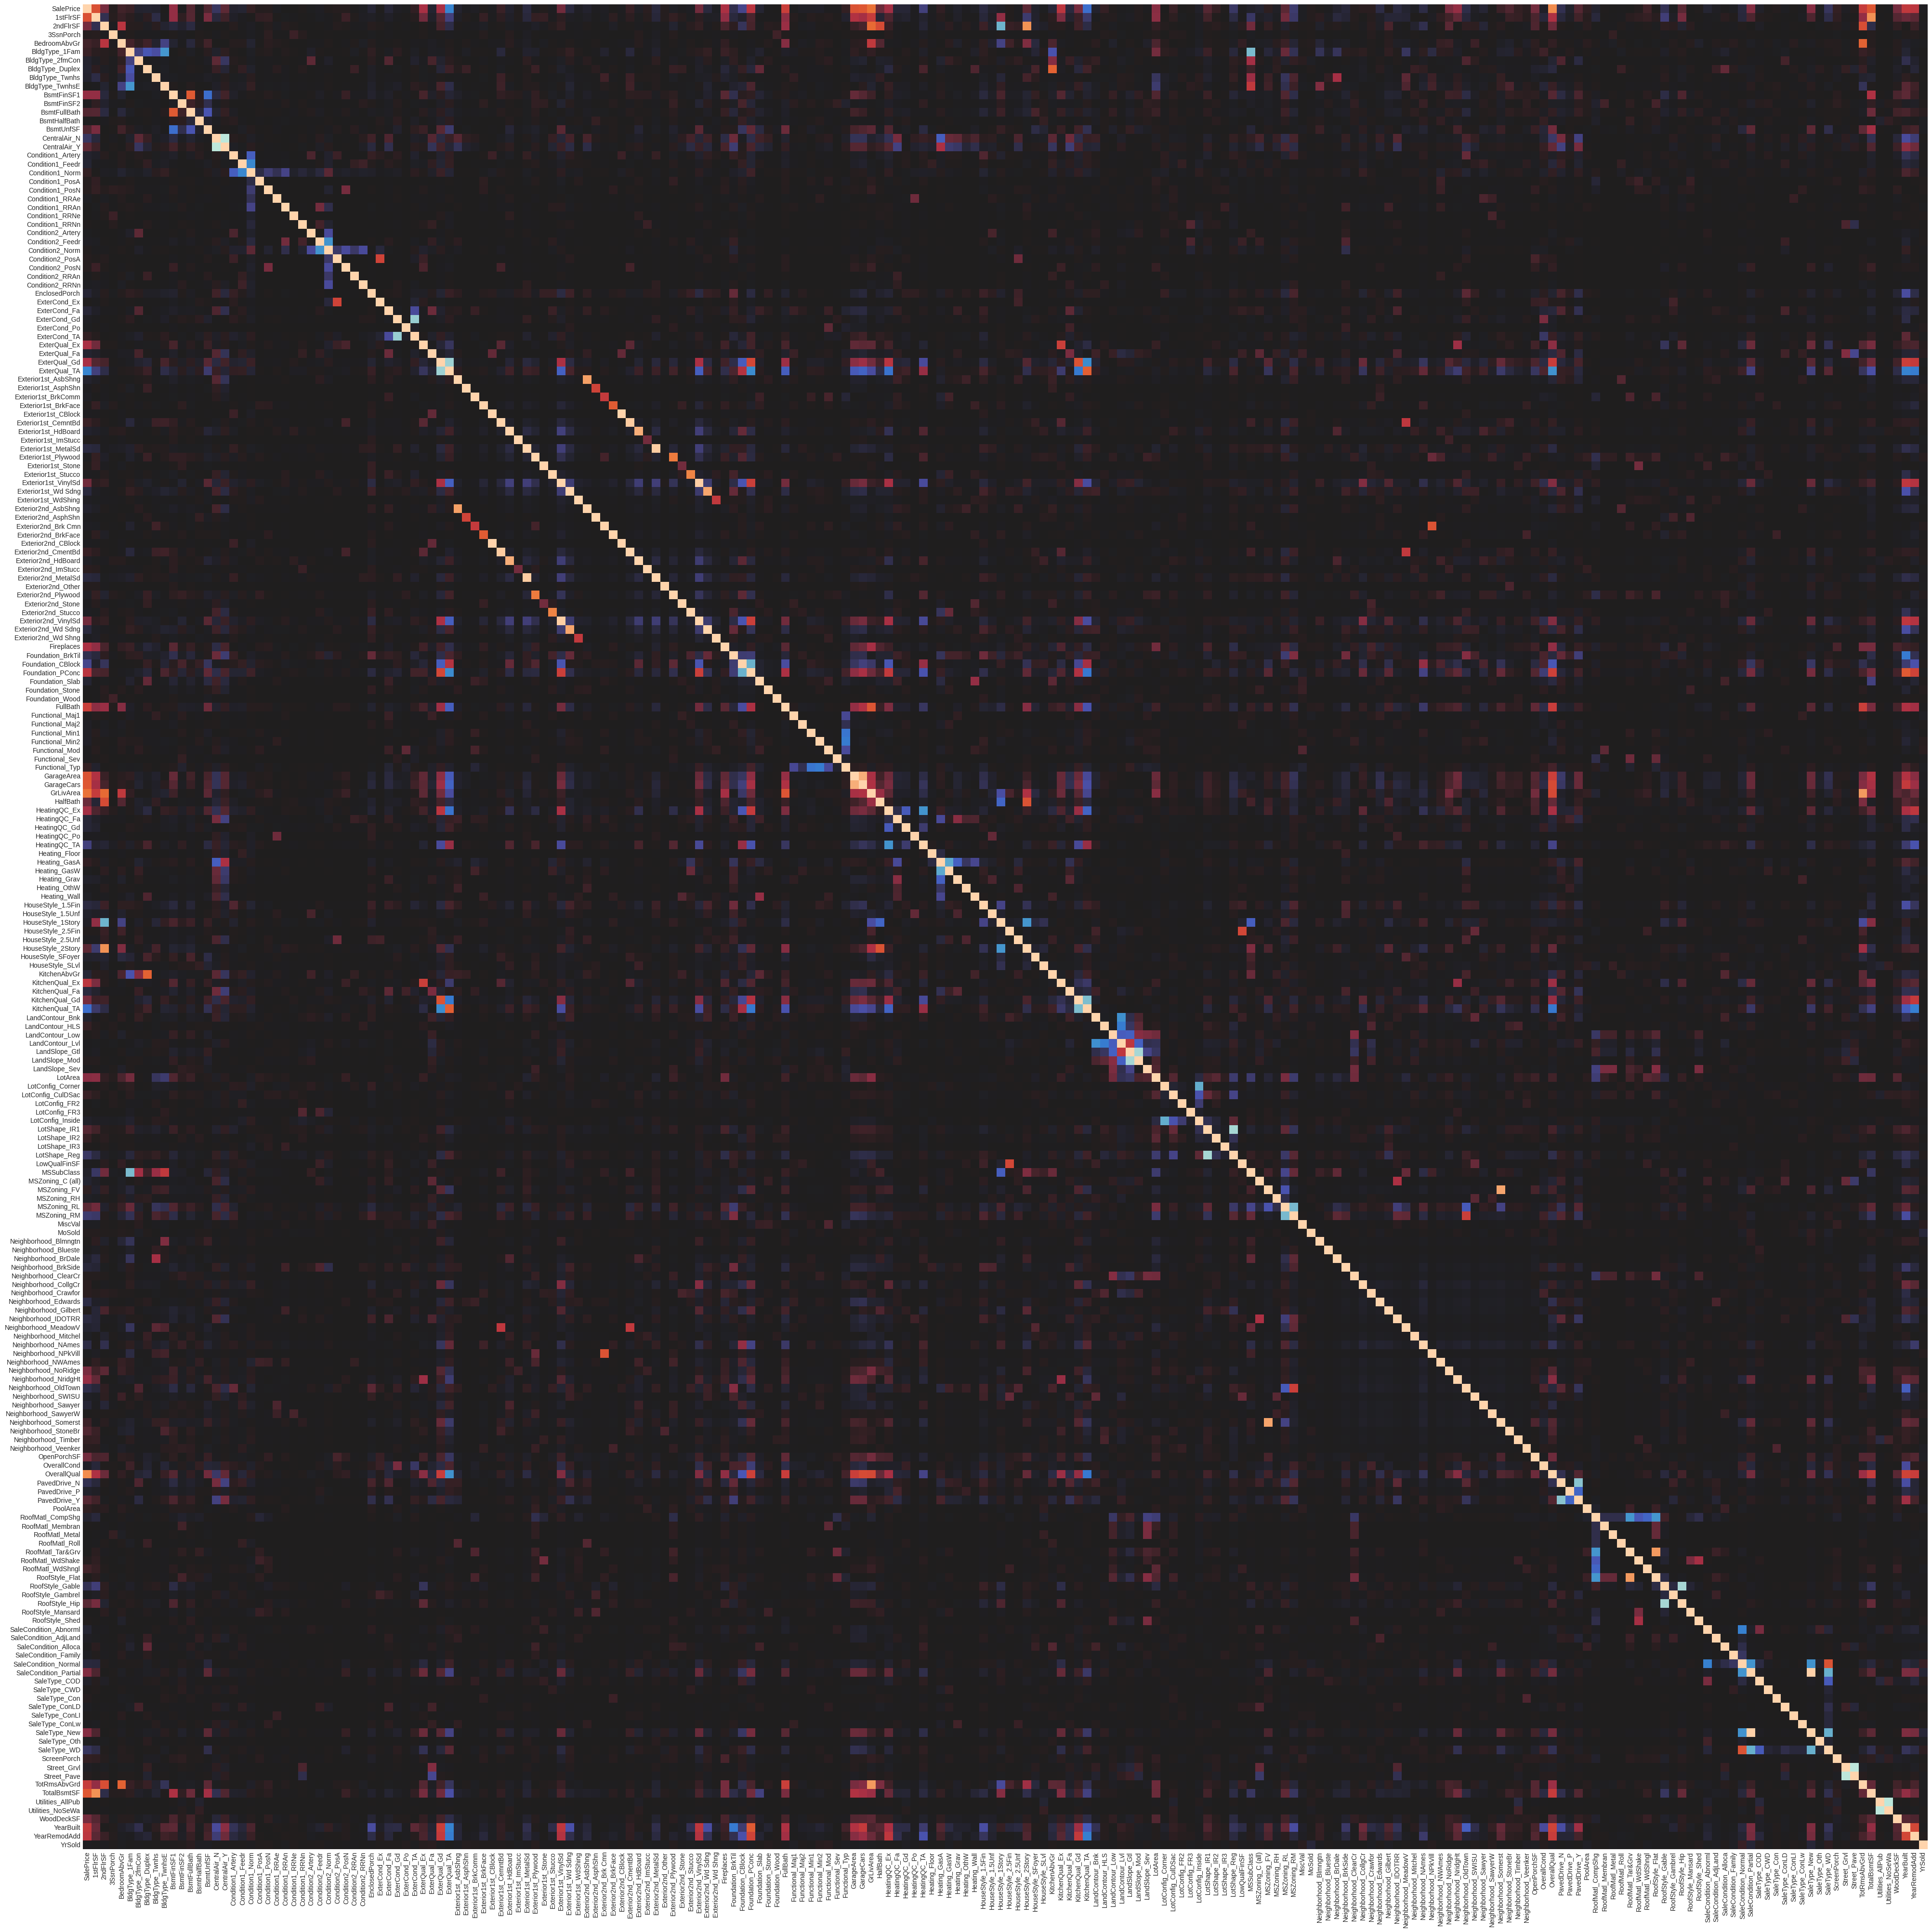

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(40, 40), layout="constrained")
ax = sns.heatmap(
    df.corr(method='pearson'),
    center=0.0,
    cmap='icefire',
    cbar=False,
    cbar_kws={'fraction': 0.01, 'anchor': (0.0, 1.0)},
    square=True,
)
# fig.suptitle('Pearson correlation', fontsize=18)
print('Red is positive. Blue is negative. Black is 0.')
print('Target is first in the list. The features are alphabetically sorted.')
print('Download the image and view it locally.')
fig.show()

# Fit linear model

In [14]:
X = df.drop(columns=['SalePrice']).copy()
y = df['SalePrice'].copy()
X = add_constant(X)

In [15]:
linear_model = sm.OLS(y, X).fit()
print(linear_model.summary2())

                            Results: Ordinary least squares
Model:                      OLS                    Adj. R-squared:           0.909     
Dependent Variable:         SalePrice              AIC:                      33598.3912
Date:                       2024-01-09 20:21       BIC:                      34570.1662
No. Observations:           1453                   Log-Likelihood:           -16615.   
Df Model:                   183                    F-statistic:              80.14     
Df Residuals:               1269                   Prob (F-statistic):       0.00      
R-squared:                  0.920                  Scale:                    5.7376e+08
---------------------------------------------------------------------------------------
                         Coef.       Std.Err.     t    P>|t|     [0.025       0.975]   
---------------------------------------------------------------------------------------
const                  -82798.5920 156446.7227 -0.5292 0.596

# Feature selection

## Sequential forward search

In [16]:
class DummyEstimator(BaseEstimator):
    # mlxtend wants to use an sklearn estimator, which is not needed here
    # (statsmodels OLS is used instead)
    # create a dummy estimator to pacify mlxtend
    def fit(self, X, y=None, **kwargs):
        return self


def neg_aic(m, X, y):
    # return -AIC from a fitted model
    lin_mod_res = sm.OLS(y, X, hasconst=True).fit()
    return -lin_mod_res.aic


def neg_bic(m, X, y):
    # return -BIC from a fitted model
    lin_mod_res = sm.OLS(y, X, hasconst=True).fit()
    return -lin_mod_res.bic


seq_selector = SFS(
    DummyEstimator(),
    k_features=(1, X.shape[1]),
    forward=True,
    floating=False,
    scoring=neg_bic,
    cv=None,
    n_jobs=-1,
    verbose=0,
    # make sure the intercept is not dropped
    fixed_features=['const'],
)

t_start_seq = time.time()
# mlxtend will mess with your dataframes if you don't .copy()
seq_res = seq_selector.fit(X.copy(), y.copy())
t_end_seq = time.time()
run_time_seq = t_end_seq - t_start_seq
seq_metrics = seq_res.get_metric_dict()

/home/florin/.local/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/florin/.local/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/214 [00:00<?, ?it/s]

best k:         36
best objective: 33708.98602877906
R2 @ best k:    0.9075677543649224
total run time: 45.827 sec
best features:  ['const', 'BedroomAbvGr', 'BldgType_1Fam', 'BsmtFinSF1', 'Condition1_Norm', 'Condition2_PosN', 'ExterQual_Ex', 'Exterior1st_BrkFace', 'Functional_Sev', 'Functional_Typ', 'GarageArea', 'GrLivArea', 'HeatingQC_Ex', 'KitchenQual_Ex', 'LandContour_HLS', 'LotArea', 'LotConfig_CulDSac', 'LowQualFinSF', 'MSSubClass', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'OverallCond', 'OverallQual', 'PoolArea', 'RoofMatl_WdShngl', 'SaleCondition_Normal', 'SaleType_New', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt']


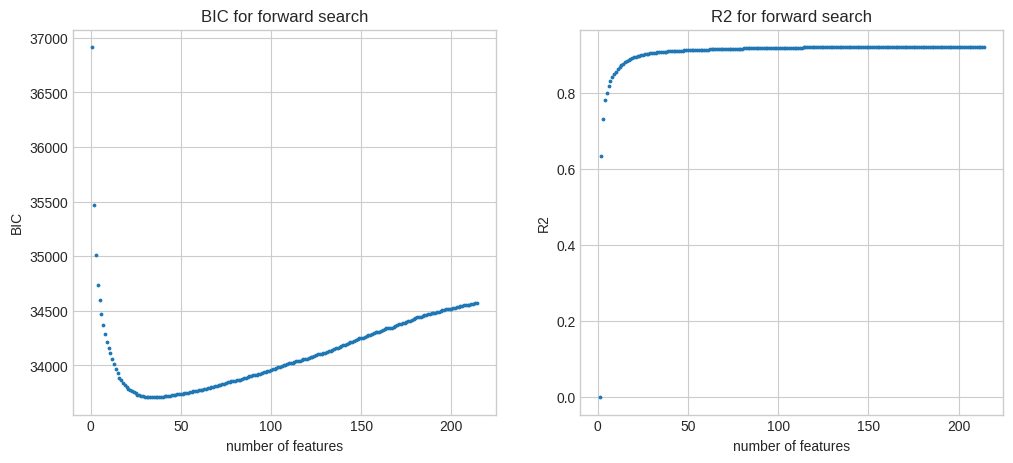

In [17]:
best_objective_seq = -np.inf
r2_of_best_k = 0
r2_list = []
best_k = 1
best_features_seq = []

# also extract R2 from the feature selection search
for k in tqdm(seq_metrics.keys()):
    r2_eval_mod = sm.OLS(y, X[list(seq_metrics[k]['feature_names'])], hasconst=True)
    r2_eval_mod_res = r2_eval_mod.fit()
    r2 = r2_eval_mod_res.rsquared
    r2_list.append(r2)
    score_k = seq_metrics[k]['avg_score']
    if score_k > best_objective_seq:
        best_objective_seq = score_k
        best_k = k
        best_features_seq = list(seq_metrics[k]['feature_names'])
        r2_of_best_k = r2

print(f'best k:         {best_k}')
print(f'best objective: {-best_objective_seq}')
print(f'R2 @ best k:    {r2_of_best_k}')
print(f'total run time: {run_time_seq:.3f} sec')
print(f'best features:  {best_features_seq}')

sfs_avg = [-seq_metrics[k]['avg_score'] for k in sorted(seq_metrics.keys())]
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(sorted(seq_metrics.keys()), sfs_avg, s=3)
ax[0].set_xticks(sorted(seq_metrics.keys()), minor=True)
ax[0].set_title('BIC for forward search')
ax[0].set_xlabel('number of features')
ax[0].set_ylabel('BIC')
ax[1].scatter(sorted(seq_metrics.keys()), r2_list, s=3)
ax[1].set_title('R2 for forward search')
ax[1].set_xlabel('number of features')
ax[1].set_ylabel('R2')
fig.show()

In [18]:
X_seq = X[best_features_seq].copy()

linear_model_seq = sm.OLS(y, X_seq, hasconst=True).fit()
print(linear_model_seq.summary2())

                            Results: Ordinary least squares
Model:                      OLS                    Adj. R-squared:           0.905     
Dependent Variable:         SalePrice              AIC:                      33518.8561
Date:                       2024-01-09 20:22       BIC:                      33708.9860
No. Observations:           1453                   Log-Likelihood:           -16723.   
Df Model:                   35                     F-statistic:              397.5     
Df Residuals:               1417                   Prob (F-statistic):       0.00      
R-squared:                  0.908                  Scale:                    5.9638e+08
---------------------------------------------------------------------------------------
                        Coef.      Std.Err.     t     P>|t|      [0.025       0.975]   
---------------------------------------------------------------------------------------
const                -932259.6333 70652.6528 -13.1950 0.0000

## Genetic algorithm

### Feature selection with a genetic algorithm, non-optimized version

Based on:

https://deap.readthedocs.io/en/master/examples/ga_onemax_short.html

In [19]:
# to maximize the objective
# fitness_weights = 1.0
# to minimize the objective
fitness_weights = -1.0

# copy the original dataframes into local copies, once
X_ga = X.copy()
y_ga = y.copy()

# 'const' (the first column) is not an actual feature, do not include it
X_features = X_ga.columns.to_list()[1:]

try:
    del creator.FitnessMax
    del creator.Individual
except Exception as e:
    pass

creator.create("FitnessMax", base.Fitness, weights=(fitness_weights,))
creator.create("Individual", array.array, typecode='b', fitness=creator.FitnessMax)

try:
    del toolbox
except Exception as e:
    pass

toolbox = base.Toolbox()
# Attribute generator
toolbox.register("attr_bool", random.randint, 0, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(X_features))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    # create True/False selector list for features, and add True at the start for 'const'
    cols_select = [True] + [i == 1 for i in list(individual)]
    # fit model using the features selected from the individual
    lin_mod = sm.OLS(y_ga, X_ga.loc[:, cols_select], hasconst=True).fit()
    return (lin_mod.bic,)


toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

random.seed(0)
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, halloffame=hof, verbose=True)

best_individual_ga_small = list(hof[0])
best_features_ga_small = [X_features[i] for i, val in enumerate(best_individual_ga_small) if val == 1]
best_objective_ga_small = sm.OLS(y_ga, X_ga[['const'] + best_features_ga_small], hasconst=True).fit().bic
print(f'best objective: {best_objective_ga_small}')
print(f'best features:  {best_features_ga_small}')

gen	nevals
0  	300   
1  	170   
2  	189   
3  	167   
4  	177   
5  	197   
6  	189   
7  	159   
8  	169   
9  	166   
10 	192   
best objective: 34113.44040982577
best features:  ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_TwnhsE', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'CentralAir_Y', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_RRAn', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAn', 'ExterCond_Po', 'ExterQual_Ex', 'Exterior1st_AsbShng', 'Exterior1st_BrkFace', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_Other', 'Exterior2nd_Wd Shng', 'Fireplaces', 'Foundation_CBlock', 'Foundation_Slab', 'Functional_Maj1', 'Functional_Maj2', 'Functional_Min1', 'Functional_Typ', 'GarageArea', 'GrLivArea', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HouseStyle_2.5Fin', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'KitchenAbvGr', 'KitchenQ

In [20]:
# clean-up
try:
    del creator.FitnessMax
    del creator.Individual
    del toolbox
except Exception as e:
    pass

### Feature selection with a genetic algorithm, optimized version

Loosely based on:

https://deap.readthedocs.io/en/master/examples/ga_onemax.html

In [21]:
# to maximize the objective
# fitness_weights = 1.0
# to minimize the objective
fitness_weights = -1.0

# copy the original dataframes into local copies, once
X_ga = X.astype(float).copy()
y_ga = y.astype(float).copy()

# 'const' (the first column) is not an actual feature, do not include it
X_features = X_ga.columns.to_list()[1:]

try:
    del creator.FitnessMax
    del creator.Individual
except Exception as e:
    pass

creator.create("FitnessMax", base.Fitness, weights=(fitness_weights,))
creator.create("Individual", array.array, typecode='b', fitness=creator.FitnessMax)

try:
    del toolbox
except Exception as e:
    pass

toolbox = base.Toolbox()
# Attribute generator
toolbox.register("attr_bool", random.randint, 0, 1)
# Structure initializers
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(X_features))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


def evalMany(individuals):
    # individuals is an array of shape (n_individuals, n_features)
    # transform it into a list of lists:
    # - a list of individuals
    # - each individual is a list of feature selectors
    ind_list = [list(i) for i in list(individuals)]
    ret = []
    for ind in ind_list:
        # create a list of True/False feature selectors from each individual
        # pre-pend True to always select the 'const' feature
        cols_select = [True] + [i == 1 for i in list(ind)]
        # fit model using the features selected from the individual
        lin_mod = sm.OLS(y_ga, X_ga.loc[:, cols_select], hasconst=True).fit()
        ret.append((lin_mod.bic,))
    return ret


# multiprocess pool to evaluate individuals
def joblib_map(f, njobs, *iters):
    return Parallel(n_jobs=njobs)(delayed(f)(*args) for args in zip(*iters))


def selElitistAndTournament(individuals, k_tournament, k_elitist=0, tournsize=3):
    # elitist tournament
    # in addition to the regular tournament, ensure the top #k_elistist individuals are preserved
    return tools.selBest(individuals, k_elitist) + tools.selTournament(individuals, k_tournament, tournsize)


# Hyperparameters
population_size = 1000
crossover_probability = 0.5
individual_mutation_probability = 0.2
gene_mutation_probability = 0.1
tournament_size = 3
elite_size = 0

n_jobs = os.cpu_count()

# register the pool as the mapper
# and the custom function as the evaluator
toolbox.register("map_multi", joblib_map)
toolbox.register("evaluate", evalMany)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=gene_mutation_probability)
# toolbox.register("select", tools.selTournament, tournsize=tournament_size)
# selection with tournament and optional elitism
toolbox.register(
    "select",
    selElitistAndTournament,
    k_tournament=population_size - elite_size,
    k_elitist=elite_size,
    tournsize=tournament_size,
)

random.seed(0)
population = toolbox.population(n=population_size)
hall_of_fame = tools.HallOfFame(1)

# Evaluate the individuals with an invalid fitness
invalid_ind = [ind for ind in population if not ind.fitness.valid]
# split the population in a list with n_jobs elements
# each element is an array containing multiple individuals
# send individuals to the evaluator
fitnesses_nested = toolbox.map_multi(toolbox.evaluate, n_jobs, np.array_split(invalid_ind, n_jobs))
fitnesses = []
for l in fitnesses_nested:
    fitnesses += l
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

hall_of_fame.update(population)

n_gen = 1000
best_objective_per_gen_ga = np.full(n_gen, np.nan)
best_objective_ga = np.nan
best_generation_ga = 0
gene_values_mean = np.zeros((n_gen, len(X_features)))
gene_maes = np.full(n_gen, np.nan)
time_to_best_ga = np.inf
# Begin the generational process
iterator = tqdm(range(1, n_gen + 1), desc='generation')
t_start = time.time()
for gen in iterator:
    t_start_loop = time.time()

    # Select the next generation of individuals
    offspring = toolbox.select(population)
    # Vary the pool of individuals via cross-over and mutation
    offspring = algorithms.varAnd(offspring, toolbox, crossover_probability, individual_mutation_probability)
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    # split the population in a list with n_jobs elements
    # each element is an array containing multiple individuals
    # send list to the evaluator pool
    fitnesses_nested = toolbox.map_multi(toolbox.evaluate, n_jobs, np.array_split(invalid_ind, n_jobs))
    fitnesses = []
    for l in fitnesses_nested:
        fitnesses += l
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    # Update the hall of fame with the generated individuals
    hall_of_fame.update(offspring)
    # Replace the current population by the offspring
    population[:] = offspring

    t_end_loop = time.time()

    # record the mean gene values across the population
    gene_values_mean[gen - 1, :] = np.array(population).mean(axis=0)
    if gen >= 2:
        gene_maes[gen - 1] = mean_absolute_error(gene_values_mean[gen - 2, :], gene_values_mean[gen - 1, :])
    # pick best individual for stats recording
    best_individual_ga = tools.selBest(population, 1)[0]
    best_objective_per_gen_ga[gen - 1] = best_individual_ga.fitness.values[0]
    if (
        best_objective_ga is np.nan
        or fitness_weights * best_individual_ga.fitness.values[0] > fitness_weights * best_objective_ga
    ):
        best_objective_ga = best_individual_ga.fitness.values[0]
        best_generation_ga = gen
        time_to_best_ga = t_end_loop - t_start
        print(
            f'gen: {gen:4n}, curr/prev gene MAE: {gene_maes[gen - 1]:.4f}, new best objective: {best_objective_ga:.4f}, time to best: {time_to_best_ga:.4f}'
        )

    if os.path.isfile('break'):
        # to gracefully break the loop, manually create a file called 'break'
        print(f'Found break file, stopping now.')
        iterator.close()
        break
g_completed_ga = gen

best_individual_ga = list(hall_of_fame[0])
best_features_ga = [X_features[i] for i, val in enumerate(best_individual_ga) if val == 1]
best_objective_ga = sm.OLS(y_ga, X_ga[['const'] + best_features_ga], hasconst=True).fit().bic

generation:   0%|          | 0/1000 [00:00<?, ?it/s]

gen:    1, curr/prev gene MAE: nan, new best objective: 34284.6978, time to best: 0.7048
gen:    2, curr/prev gene MAE: 0.0235, new best objective: 34237.2278, time to best: 1.3578
gen:    3, curr/prev gene MAE: 0.0256, new best objective: 34214.3002, time to best: 2.0708
gen:    4, curr/prev gene MAE: 0.0260, new best objective: 34180.4923, time to best: 2.7407
gen:    5, curr/prev gene MAE: 0.0246, new best objective: 34154.9253, time to best: 3.4125
gen:    6, curr/prev gene MAE: 0.0285, new best objective: 34139.4376, time to best: 4.0658
gen:    7, curr/prev gene MAE: 0.0290, new best objective: 34117.7662, time to best: 4.7011
gen:    8, curr/prev gene MAE: 0.0265, new best objective: 34100.1204, time to best: 5.3262
gen:   10, curr/prev gene MAE: 0.0234, new best objective: 34087.7337, time to best: 6.7710
gen:   11, curr/prev gene MAE: 0.0242, new best objective: 34056.6133, time to best: 7.3743
gen:   12, curr/prev gene MAE: 0.0278, new best objective: 34043.8180, time to best

best objective:  33705.569572544795
best generation: 787
time to best:    159.648 sec
best features:   ['BedroomAbvGr', 'BldgType_1Fam', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Condition1_Norm', 'Condition2_PosN', 'ExterQual_Ex', 'Exterior1st_BrkFace', 'Functional_Sev', 'Functional_Typ', 'GarageArea', 'GrLivArea', 'HeatingQC_Ex', 'KitchenQual_Ex', 'LandContour_HLS', 'LotArea', 'LotConfig_CulDSac', 'LowQualFinSF', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'OverallCond', 'OverallQual', 'PoolArea', 'RoofMatl_WdShngl', 'SaleCondition_Normal', 'SaleType_New', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt']


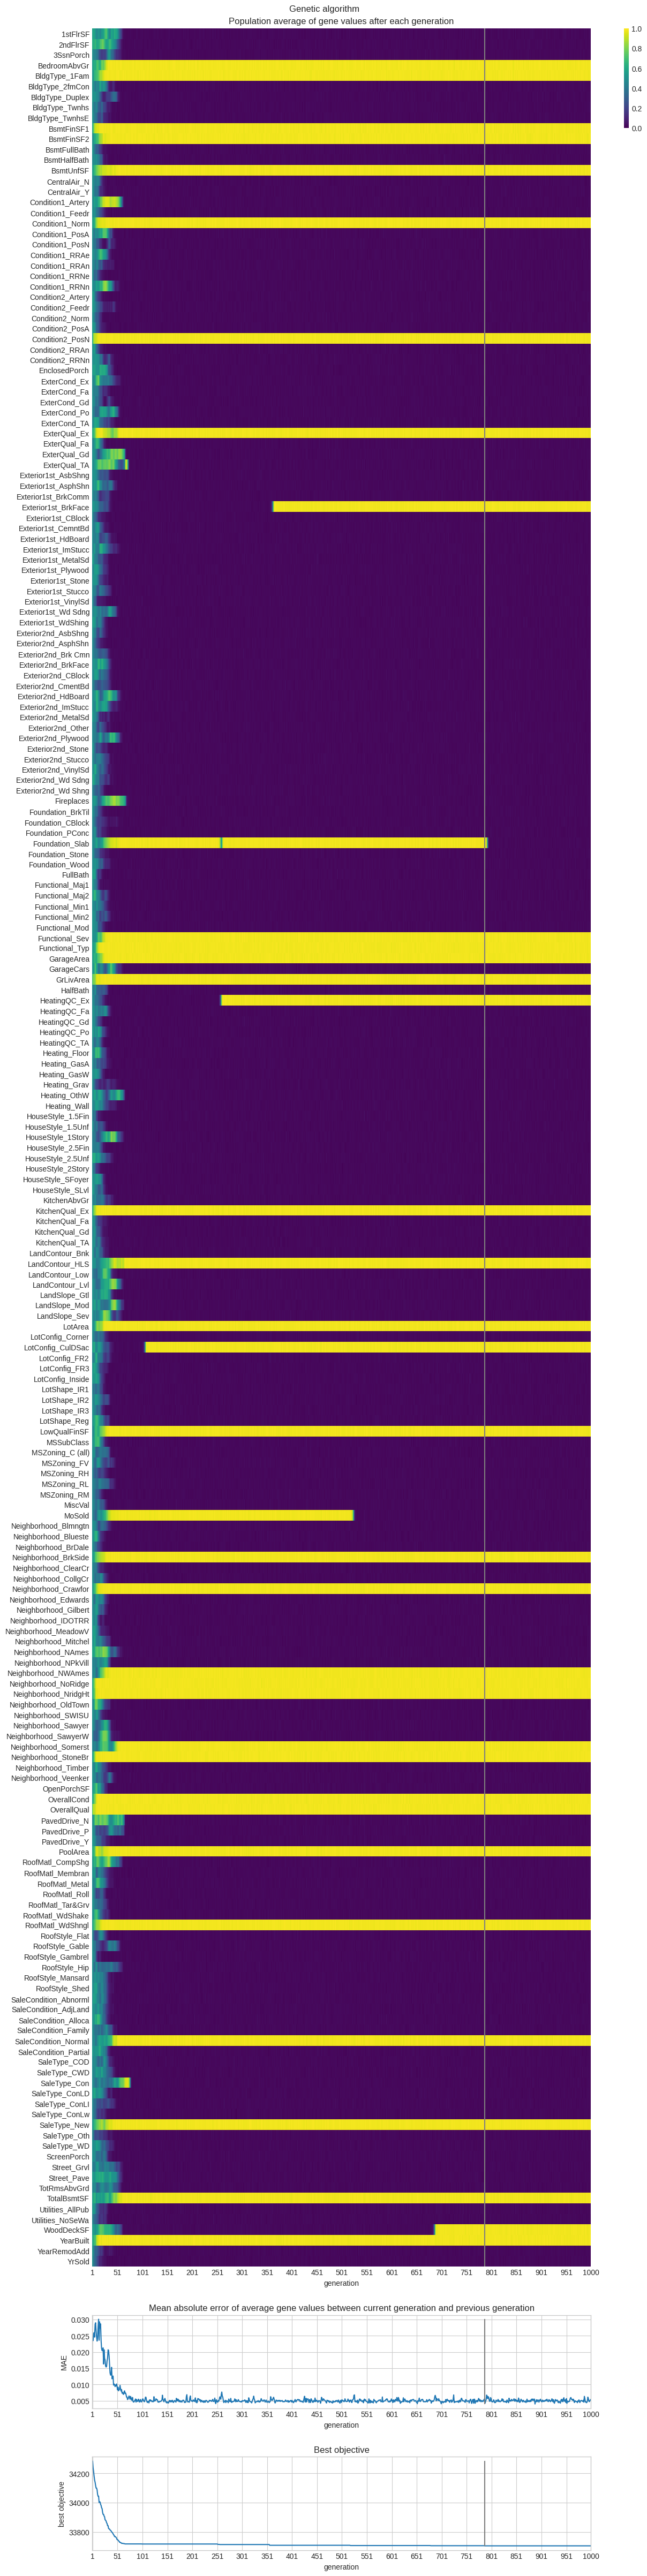

In [29]:
print(f'best objective:  {best_objective_ga}')
print(f'best generation: {best_generation_ga}')
print(f'time to best:    {time_to_best_ga:.3f} sec')
print(f'best features:   {best_features_ga}')

gvm_df = (
    pd.DataFrame(gene_values_mean, columns=X_features, index=range(1, gene_values_mean.shape[0] + 1))
    .sort_index(axis=1)
    .iloc[:g_completed_ga]
)
if g_completed_ga > 20:
    x_ticks = list(range(1, g_completed_ga + 1, round(g_completed_ga / 20)))
else:
    x_ticks = list(range(1, g_completed_ga + 1))
if x_ticks[-1] != g_completed_ga:
    x_ticks.append(g_completed_ga)

fig, ax = plt.subplots(3, 1, sharex=True, height_ratios=[24, 1, 1], figsize=(12, 48), layout='constrained')

sns.heatmap(
    gvm_df.sort_index(axis=1).T,
    vmin=0.0,
    vmax=1.0,
    cmap='viridis',
    cbar=True,
    cbar_kws={'fraction': 0.01, 'anchor': (0.0, 1.0)},
    ax=ax[0],
)
ax[0].set_title('Population average of gene values after each generation')
ax[0].axvline(x=best_generation_ga, color='C7')
ax[0].set_xlabel('generation')
ax[0].tick_params(axis='both', reset=True)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_ticks)

ax[1].set_xlabel('generation')
ax[1].plot(list(range(2, g_completed_ga + 1)), gene_maes[1:g_completed_ga])
ax[1].vlines(
    x=best_generation_ga, ymin=gene_maes[1:g_completed_ga].min(), ymax=gene_maes[1:g_completed_ga].max(), colors='C7'
)
ax[1].set_xlabel('generation')
ax[1].set_ylabel('MAE')
ax[1].set_title('Mean absolute error of average gene values between current generation and previous generation')
ax[1].tick_params(axis='both', reset=True)

ax[2].set_xlabel('generation')
ax[2].plot(list(range(1, g_completed_ga + 1)), best_objective_per_gen_ga[:g_completed_ga])
ax[2].vlines(
    x=best_generation_ga,
    ymin=min(best_objective_per_gen_ga[:g_completed_ga]),
    ymax=max(best_objective_per_gen_ga[:g_completed_ga]),
    colors='C7',
)
ax[2].set_xlabel('generation')
ax[2].set_ylabel('best objective')
ax[2].set_title('Best objective')

fig.suptitle('Genetic algorithm')
fig.savefig('ga-performance.png')
fig.show()

## CMA-ES

### CMA-ES demo

Find the minimum of the Rastrigin function. It should be at (0, 0). The function has many minima and maxima around the origin.

#### Run CMA-ES until convergence

Record all intermediate states.

In [23]:
def rastrigin(config):
    # the objective function
    score = (
        config[0] ** 2 - 10 * np.cos(2 * np.pi * config[0]) + config[1] ** 2 - 10 * np.cos(2 * np.pi * config[1]) + 20
    )
    return score


dim = 2
optimizer = CMA(mean=np.zeros(dim), sigma=2.0, seed=1)
pop_size = optimizer.population_size

evals = 0
solutions = {}
g = 0
while True:
    sol_gen = []
    for _ in range(pop_size):
        sample = optimizer.ask()
        value = rastrigin(sample)
        evals += 1
        sol_gen.append((sample, value))
    solutions[g] = sol_gen
    optimizer.tell(sol_gen)
    g += 1

    if optimizer.should_stop():
        break

#### Render frames with all intermediate steps

In [24]:
img_size = 1200
zval = np.full((img_size + 1, img_size + 1), np.nan)


def coord_trans(c):
    return -6 + c * 12 / img_size


def coord_rev(c):
    return 600 + 100 * c


for x1 in range(img_size + 1):
    for x2 in range(img_size + 1):
        zval[x1, x2] = rastrigin([coord_trans(x1), coord_trans(x2)])

for k in tqdm(solutions.keys()):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), layout='constrained')
    ax.pcolormesh(zval, cmap='viridis')
    for p in solutions[k]:
        coord = p[0]
        px = coord_rev(coord[0])
        py = coord_rev(coord[1])
        ax.scatter(px, py, s=5, c='red')
    ax.set_xticks(list(range(0, 1201, 100)))
    ax.set_xticklabels(range(-6, 7))
    ax.set_yticks(list(range(0, 1201, 100)))
    ax.set_yticklabels(range(6, -7, -1))
    fig.savefig(f'frame{str(k).zfill(3)}.png')
    plt.close(fig)

  0%|          | 0/101 [00:00<?, ?it/s]

In [25]:
!rm -f cmaes*.gif
!ffmpeg -i frame%03d.png -r 24 cmaes.gif
!rm -f frame*.png

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

#### The evolution in time of the CMA-ES model

![demo](cmaes.gif)

### Feature selection with CMA-ES, simple version

Based on:

https://github.com/CyberAgentAILab/cmaes/blob/main/examples/cmaes_with_margin_binary.py

In [26]:
def cma_objective(fs):
    features_use = ['const'] + [f for i, f in enumerate(features_select) if fs[i,] == 1]
    lin_mod = sm.OLS(y_cmaes, X_cmaes[features_use], hasconst=True).fit()
    return lin_mod.bic


X_cmaes = X.copy()
y_cmaes = y.copy()
features_select = [f for f in X_cmaes.columns if f != 'const']

dim = len(features_select)
bounds = np.tile([0, 1], (dim, 1))
steps = np.ones(dim)
optimizer = CMAwM(mean=np.full(dim, 0.5), sigma=1 / 6, bounds=bounds, steps=steps, n_max_resampling=10 * dim, seed=0)

max_gen = 100
best_objective_cmaes_small = np.inf
best_sol_raw_cmaes_small = None
for gen in tqdm(range(max_gen)):
    solutions = []
    for _ in range(optimizer.population_size):
        x_for_eval, x_for_tell = optimizer.ask()
        value = cma_objective(x_for_eval)
        solutions.append((x_for_tell, value))
        if value < best_objective_cmaes_small:
            best_objective_cmaes_small = value
            best_sol_raw_cmaes_small = x_for_eval
    optimizer.tell(solutions)

best_features_cmaes_small = [
    features_select[i] for i, val in enumerate(best_sol_raw_cmaes_small.tolist()) if val == 1.0
]
print(f'best objective: {best_objective_cmaes_small}')
print(f'best features:  {best_features_cmaes_small}')

  0%|          | 0/100 [00:00<?, ?it/s]

best objective: 33831.020567246705
best features:  ['BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtUnfSF', 'Condition1_Feedr', 'Condition1_Norm', 'Condition2_PosN', 'ExterQual_Ex', 'ExterQual_Fa', 'Exterior1st_Plywood', 'Exterior2nd_CBlock', 'Fireplaces', 'Foundation_PConc', 'Foundation_Wood', 'Functional_Sev', 'Functional_Typ', 'GarageArea', 'GrLivArea', 'HouseStyle_2.5Fin', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'LandContour_Bnk', 'LandSlope_Mod', 'LotArea', 'LotConfig_CulDSac', 'MSSubClass', 'MSZoning_FV', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_Gilbert', 'Neighborhood_Mitchel', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_StoneBr', 'OverallCond', 'OverallQual', 'PoolArea', 'RoofMatl_CompShg', 'RoofMatl_WdShngl', 'RoofStyle_Hip', 'SaleCondition_Abnorml', 'SaleCondition_Partial', 'SaleType_WD', 'Street_Pave', 'Utilities_AllPub', 'YearBuilt', 'YearRemodAdd']


### Feature selection with CMA-ES, complex version

In [27]:
def cma_objective(fs):
    features_use = ['const'] + [f for i, f in enumerate(features_select) if fs[i,] == 1]
    lin_mod = sm.OLS(y_cmaes, X_cmaes[features_use], hasconst=True).fit()
    return lin_mod.bic


# copy the original dataframes into local copies, once
X_cmaes = X.copy()
y_cmaes = y.copy()

rs = np.random.RandomState(seed=0)
features_select = [f for f in X_cmaes.columns if f != 'const']
n_features = len(features_select)
cma_bounds = np.tile([0, 1], (n_features, 1))
cma_steps = np.ones(n_features)
n_max_resampling = 10 * n_features
mean = np.full(n_features, 0.5)
sigma = 1 / 6
pop_size = 4 + math.floor(3 * math.log(n_features))
margin = 1 / (n_features * pop_size)

optimizer = CMAwM(
    mean=mean,
    sigma=sigma,
    bounds=cma_bounds,
    steps=cma_steps,
    n_max_resampling=n_max_resampling,
    seed=0,
    population_size=pop_size,
    margin=margin,
)

gen_max = 1000
best_objective_cmaes = np.inf
best_generation_cmaes = 0
best_sol_raw_cmaes = None
history_values_cmaes = np.full((gen_max,), np.nan)
history_values_best_cmaes = np.full((gen_max,), np.nan)
time_to_best_cmaes = np.inf
solutions_avg = np.full((gen_max, n_features), np.nan)

iterator = tqdm(range(gen_max), desc='generation')
t_start_cmaes = time.time()
for generation in iterator:
    best_value_gen = np.inf
    # solutions fed back to the optimizer
    solutions_float = []
    # binary-truncated solutions - the yes/no answers we're looking for
    solutions_binary = np.full((pop_size, n_features), np.nan)
    vals = np.full((pop_size,), np.nan)

    for i in range(optimizer.population_size):
        seed = rs.randint(1, 2**16) + generation
        optimizer._rng.seed(seed)
        fs_for_eval, fs_for_tell = optimizer.ask()
        solutions_binary[i,] = fs_for_eval
        value = cma_objective(fs_for_eval)
        vals[i] = value
        solutions_float.append((fs_for_tell, value))
    optimizer.tell(solutions_float)
    solutions_avg[generation,] = solutions_binary.mean(axis=0)

    best_value_gen = vals.min()
    t_end_loop_cmaes = time.time()
    if best_value_gen < best_objective_cmaes:
        best_objective_cmaes = best_value_gen
        best_generation_cmaes = generation
        best_sol_raw_cmaes = solutions_binary[np.argmin(vals),]
        time_to_best_cmaes = t_end_loop_cmaes - t_start_cmaes
        print(f'gen: {best_generation_cmaes:5n}, new best objective: {best_objective_cmaes:.4f}')
    history_values_cmaes[generation] = best_value_gen
    history_values_best_cmaes[generation] = best_objective_cmaes

    if optimizer.should_stop():
        print(f'Optimizer decided to stop.')
        iterator.close()
        break
    if os.path.isfile('break'):
        # to gracefully break the loop, manually create a file called 'break'
        print(f'Found break file, stopping now.')
        iterator.close()
        break
gen_completed_cmaes = generation

best_features_cmaes = [features_select[i] for i, val in enumerate(best_sol_raw_cmaes.tolist()) if val == 1.0]

generation:   0%|          | 0/1000 [00:00<?, ?it/s]

gen:     0, new best objective: 34350.3868
gen:     1, new best objective: 34344.9318
gen:     2, new best objective: 34281.3179
gen:     4, new best objective: 34218.7897
gen:     7, new best objective: 34207.6849
gen:     8, new best objective: 34205.0641
gen:     9, new best objective: 34185.6031
gen:    10, new best objective: 34139.4186
gen:    11, new best objective: 34097.6551
gen:    16, new best objective: 34087.4441
gen:    17, new best objective: 34072.3176
gen:    18, new best objective: 34057.7747
gen:    19, new best objective: 34044.1383
gen:    20, new best objective: 34038.7780
gen:    21, new best objective: 34032.0660
gen:    23, new best objective: 34025.2939
gen:    24, new best objective: 34013.8857
gen:    25, new best objective: 34013.4920
gen:    27, new best objective: 33994.2684
gen:    30, new best objective: 33990.5586
gen:    31, new best objective: 33971.0754
gen:    34, new best objective: 33969.8550
gen:    37, new best objective: 33953.0413
gen:    39,

best objective:  33703.070530508514
best generation: 921
time to best:    48.282 sec
best features:   ['BedroomAbvGr', 'BldgType_1Fam', 'BsmtFinSF1', 'Condition1_Norm', 'Condition2_PosN', 'ExterQual_Ex', 'Exterior1st_BrkFace', 'Functional_Sev', 'Functional_Typ', 'GarageCars', 'GrLivArea', 'HeatingQC_Ex', 'KitchenQual_Ex', 'LandContour_HLS', 'LotArea', 'LowQualFinSF', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'OverallCond', 'OverallQual', 'PoolArea', 'RoofMatl_WdShngl', 'SaleCondition_Normal', 'SaleType_New', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt']


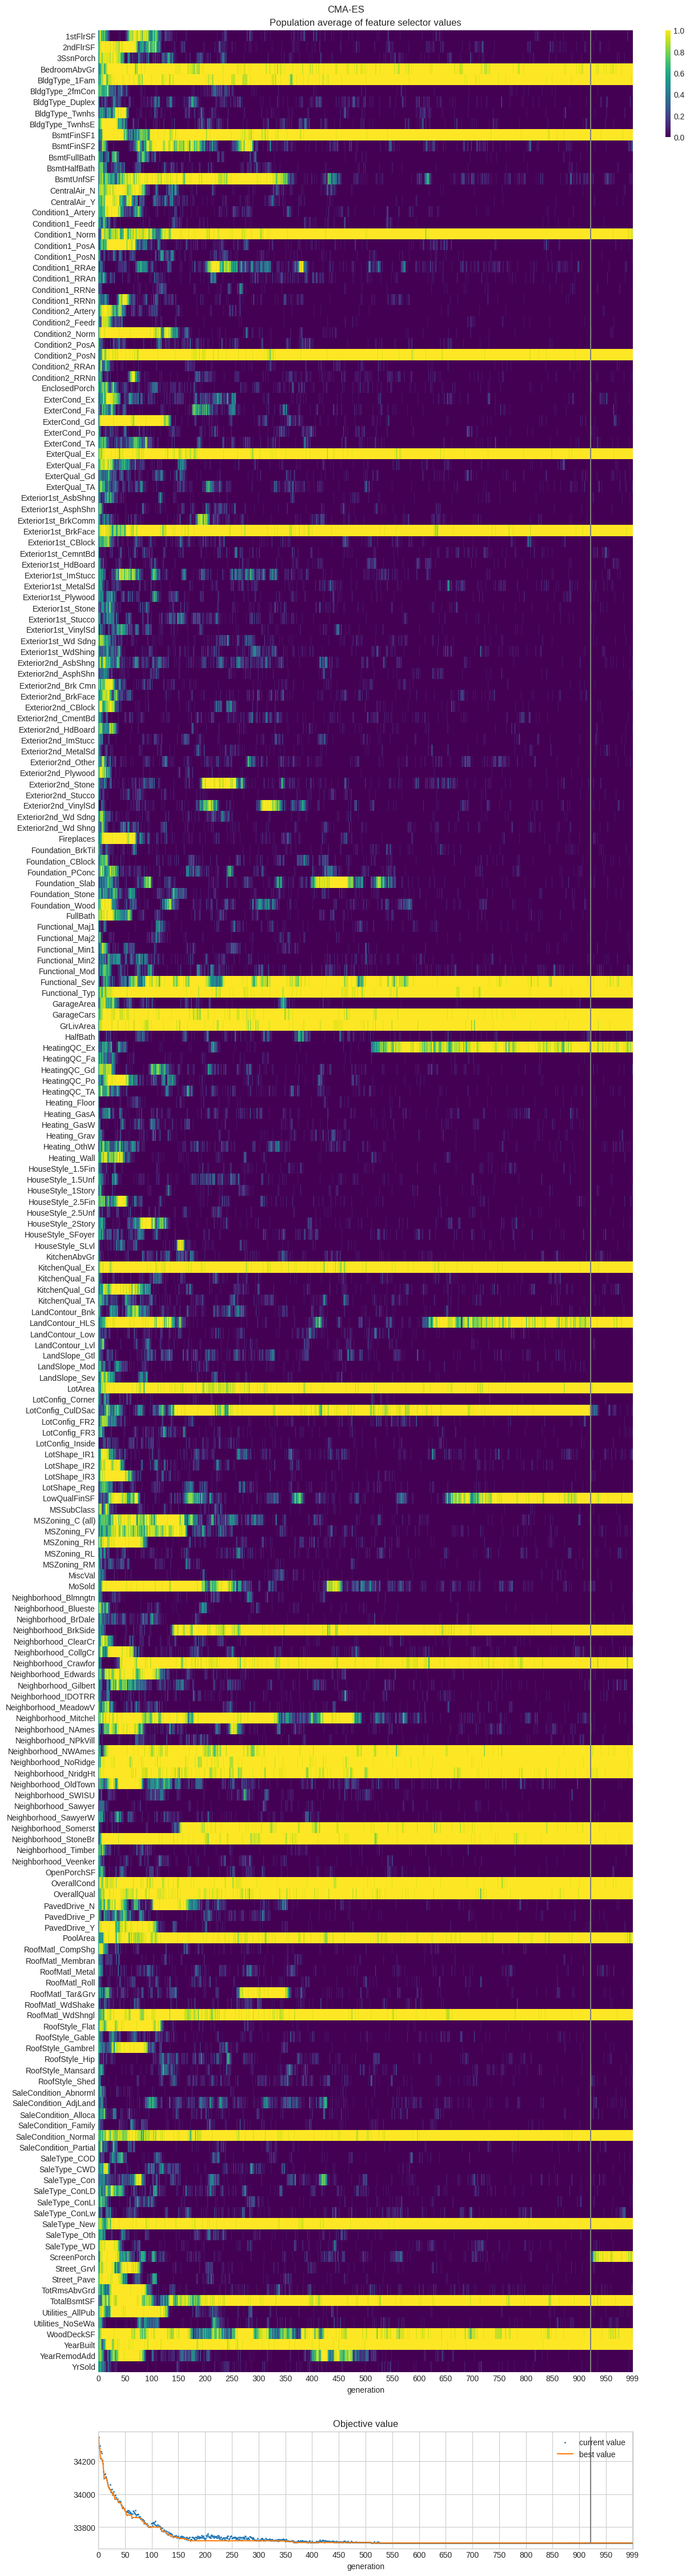

In [30]:
print(f'best objective:  {best_objective_cmaes}')
print(f'best generation: {best_generation_cmaes}')
print(f'time to best:    {time_to_best_cmaes:.3f} sec')
print(f'best features:   {best_features_cmaes}')

cma_mv_df = pd.DataFrame(solutions_avg, columns=features_select).iloc[: gen_completed_cmaes + 1]

if gen_completed_cmaes > 20:
    x_ticks = list(range(0, gen_completed_cmaes, round(gen_completed_cmaes / 20)))
else:
    x_ticks = list(range(0, gen_completed_cmaes))
if x_ticks[-1] != gen_completed_cmaes:
    x_ticks.append(gen_completed_cmaes)

fig, ax = plt.subplots(2, 1, sharex=True, height_ratios=[20, 1], figsize=(12, 45), layout='constrained')
sns.heatmap(
    cma_mv_df.T,
    vmin=0.0,
    vmax=1.0,
    cmap='viridis',
    cbar=True,
    cbar_kws={'fraction': 0.01, 'anchor': (0.0, 1.0)},
    ax=ax[0],
)
ax[0].axvline(x=best_generation_cmaes, color='C7')
ax[0].tick_params(axis='both', reset=True)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_ticks)
ax[0].set_title('Population average of feature selector values')
ax[0].set_xlabel('generation')

ax[1].scatter(
    range(gen_completed_cmaes + 1), history_values_cmaes[: gen_completed_cmaes + 1], s=1, label='current value'
)
ax[1].plot(
    range(gen_completed_cmaes + 1), history_values_best_cmaes[: gen_completed_cmaes + 1], color='C1', label='best value'
)
ax[1].vlines(
    x=best_generation_cmaes,
    ymin=history_values_cmaes[: gen_completed_cmaes + 1].min(),
    ymax=history_values_cmaes[: gen_completed_cmaes + 1].max(),
    colors='C7',
)
ax[1].tick_params(axis='both', reset=True)
ax[1].legend()
ax[1].set_title('Objective value')
ax[1].set_xlabel('generation')
fig.suptitle('CMA-ES')
fig.savefig('cmaes-performance.png')
fig.show()